The content is based on Martin Krasser's article on non-parametric methods for supervised learning. We will use Gaussian processes (GPs) to infer a distribution over functions directly, instead of inferring a distribution over parameters. A Gaussian process defines a prior over functions. After having observed some function values it can be converted into a posterior over functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from gaussian_preprocess_util import plot_gp

### Kernel function

In [2]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel
    Args:
        X1:Array of m points
        X2:Array of n points
    Returns:
        (m x n) matrix
    """
    sqdist = X1**2 + np.sum(X2**2, 1) - 2*np.dot(X1,X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [3]:
X = np.arange(-5, 10, 0.2).reshape(-1,1)

# mean and cov of prior
mu = np.zeros(X.shape)
cov = kernel(X,X)

print(cov)

[[1.00000000e+00 9.80198673e-01 9.23116346e-01 ... 9.38313827e-46
  5.16290482e-47 2.72940726e-48]
 [9.80198673e-01 1.00000000e+00 9.80198673e-01 ... 1.63843922e-44
  9.38313827e-46 5.16290482e-47]
 [9.23116346e-01 9.80198673e-01 1.00000000e+00 ... 2.74878501e-43
  1.63843922e-44 9.38313827e-46]
 ...
 [9.38313827e-46 1.63843922e-44 2.74878501e-43 ... 1.00000000e+00
  9.80198673e-01 9.23116346e-01]
 [5.16290482e-47 9.38313827e-46 1.63843922e-44 ... 9.80198673e-01
  1.00000000e+00 9.80198673e-01]
 [2.72940726e-48 5.16290482e-47 9.38313827e-46 ... 9.23116346e-01
  9.80198673e-01 1.00000000e+00]]


### Prior

Define prior with mean zero and covariance matrix computed from the kernel function.

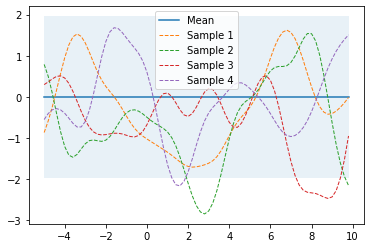

In [4]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

samples = np.random.multivariate_normal(mu.ravel(), cov, 4)
plot_gp(mu, cov, X, samples=samples)

### Prediction from noise-free training data 

In [5]:
from numpy.linalg import inv

def posterior(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    """
    Compute parameters for posterior distribution
    Args:
        X_s: new input locations (n x d)
        X_train: training locations (m x d)
        Y_train: training targets (m x 1)
        l: Kernel length parameter
        sigma_f: Kernel vertical variation parameter
        sigma_y: noise parameter
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n)
    """
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

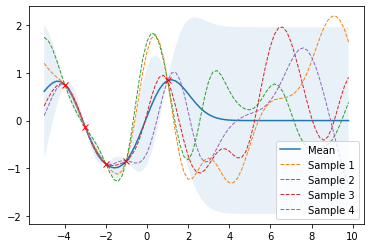

In [6]:
# Noise-free training data
X_train = np.array([-4,-3,-2,-1,1]).reshape(-1,1)
Y_train = np.sin(X_train)

mu_s, cov_s = posterior(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 4)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

### Prediction from noisy training data 

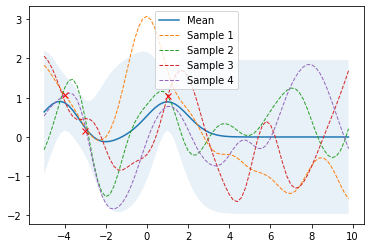

In [7]:
noise = 0.4

# Noisy training data
X_train = np.array([-3,-4,1]).reshape(-1,1)
Y_train = np.sin(X_train) + noise * np.random.rand(*X_train.shape)

mu_s, cov_s = posterior(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 4)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)